# From    
https://github.com/pogam/ExtractRect/blob/master/extractRect.py

# Imports

In [2]:
import numpy as np
from scipy import ndimage, optimize
import pdb 
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import multiprocessing
import datetime
import os
from sklearn.model_selection import train_test_split
from itertools import product
from matplotlib import rcParams
from extractRect import *

# Functions

In [3]:
nsh = np.shape
def set_all_rcParams(true_or_false):
    rcParams['ytick.left']=true_or_false
    rcParams['xtick.bottom']=true_or_false
    rcParams['ytick.labelleft'] = true_or_false
    rcParams['xtick.labelbottom'] = true_or_false

In [4]:
def adjust_rect_to_size(box_gan_size, x1,x2,y1,y2):
    '''Adjust the rect coords to crop or pad the image to obtain the desired size.
    Depending on the coords we crop/pad on top or bottom and on left or right'''
    pad_or_crop_0 = box_gan_size-(x2-x1)
    pad_or_crop_1 = box_gan_size-(y2-y1)
    if pad_or_crop_0 > 0: # pad
        if x2 > 200: # pad to the left
            x1 = x1 - pad_or_crop_0
        else: # pad to the right
            x2 = x2 + pad_or_crop_0
    else:
        if x2 > 200: #crop left
            x2 += pad_or_crop_0
        else: # crop right
            x1 -= pad_or_crop_0

    if pad_or_crop_1 > 0: #pad
        if y2 > 200: # pad top
            y1 -= pad_or_crop_1
        else: # pad below
            y2 += pad_or_crop_1
    else: #crop
        if y2 > 200: #crop below
            y2 += pad_or_crop_1
        else: # crop top
            y1 -= pad_or_crop_1
    return x1,x2,y1,y2

# Select files

In [84]:
path_source = '/home/om18/Documents/KCL/Feb 5 19 - Deep image prior/deep-image-prior/dip results all 3/arrays/'
path_A = f'{path_source}orig/'
path_B = f'{path_source}last/'
path_box = '/data/OMM/Datasets/LIDC_other_formats/LIDC slices inpainting/nodule to focus on/'

In [109]:
files = os.listdir(f'{path_A}')
files = np.sort(files)

In [110]:
fold = 1
files_train, files_test = train_test_split(files, test_size=0.2, random_state=fold)

In [111]:
# Get the masks for the nodule and the area outside the lungs
path_outside_lungs = '/data/OMM/Datasets/LIDC_other_formats/LIDC slices inpainting/outside lungs mask/'
files_nodule_ = [f"{path_box}{i.split('orig ')[-1].replace('npy','npz')}" for i in files_train]
files_outside = [f"{path_outside_lungs}{i.split('orig ')[-1].replace('npy','npz')}" for i in files_train]       

In [112]:
np.where(files=='orig LIDC-IDRI-0078_nodule_000.npy')

(array([229]),)

In [116]:
# Get the images for the GAN
file_idx = 229
files_A = files_train
files_B = [i.replace('orig ', 'last ') for i in files_A]
imgA = np.load(f'{path_A}{files_A[file_idx]}')
imgB = np.load(f'{path_B}{files_B[file_idx]}')

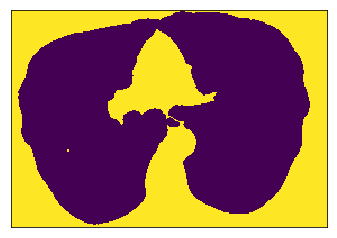

In [117]:
# Get the masks to define the box around the nodule
outside = np.load(files_outside[file_idx])
outside = outside.f.arr_0
nodule_mask = np.load(files_nodule_[file_idx])
nodule_mask = nodule_mask.f.arr_0
# plt.imshow(outside)
plt.imshow(nodule_mask | outside)

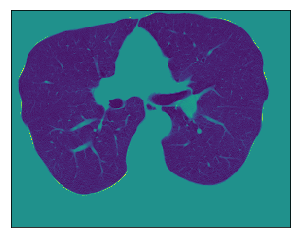

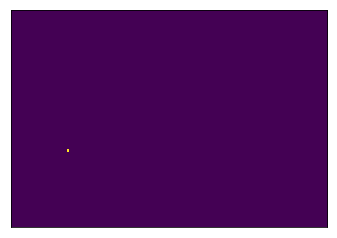

In [118]:
plt.imshow(imgA), 
plt.figure()
plt.imshow(nodule_mask)

In [119]:
#Pad nodule_mask and outside mask to have the same image size as imgA and imgB
pad0 = nsh(imgA)[0] - nsh(nodule_mask)[0]
pad1 = nsh(imgA)[1] - nsh(nodule_mask)[1]
nodule_mask = np.pad(nodule_mask, ((0,pad0),(0,pad1)), mode='constant', constant_values=0)
outside = np.pad(outside, ((0,pad0),(0,pad1)), mode='constant', constant_values=1)

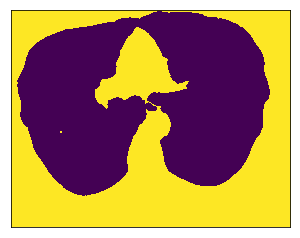

In [120]:
plt.imshow(outside | nodule_mask)

### Set some limits the box coordinates close to the nodule

In [121]:
imgA = imgA * (1 - outside)

In [122]:
box_gan_size = 128
# We don't use the full length because the box obtained might not contain the nodule
rect_size = int(128 * .5)
rect_half = rect_size // 2

yy, xx = np.where(nodule_mask == 1)
y_max = np.max(yy)
y_min = np.min(yy)
x_max = np.max(xx)
x_min = np.min(xx)
y_max, y_min, x_max, x_min

(126, 125, 51, 50)

In [123]:
mask_far_from_nodule = np.ones_like(outside)

max_to_use_x = np.min((np.shape(outside)[1], x_max + rect_size)) - 1
max_to_use_y = np.min((np.shape(outside)[0], y_max + rect_size)) - 1
min_to_use_x = np.max((0, x_min - rect_size)) - 1
min_to_use_y = np.max((0, y_min - rect_size)) - 1

In [124]:
indices_fill_x = np.arange(min_to_use_x,max_to_use_x)
indices_fill_y = np.arange(min_to_use_y,max_to_use_y)

In [125]:
coords_ones = list(product(indices_fill_y, indices_fill_x))
for i in coords_ones: mask_far_from_nodule[i] = 0

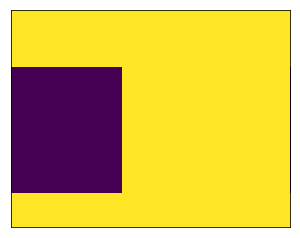

In [126]:
plt.imshow(mask_far_from_nodule)

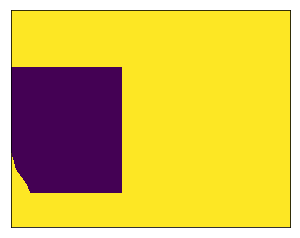

In [127]:
### Erode the lung because many nodules are close to the border
kernel = np.ones((40,40))
outside2 = cv2.erode(outside, kernel, iterations = 1)
outside = outside2 | mask_far_from_nodule
plt.imshow(outside)

### Find the maximum rectangle

In [128]:
rect_coord_ori, angle, coord_out_rot= findRotMaxRect(outside, flag_opt=True, nbre_angle=4, \
flag_parallel=False, flag_out='rotation', flag_enlarge_img=False, limit_image_size=100)

In [129]:
x1 = rect_coord_ori[2][1]
y1 = rect_coord_ori[0][0]
width = (np.shape(outside)[1] - rect_coord_ori[2][1]) - (np.shape(outside)[1] - rect_coord_ori[0][1])
height = rect_coord_ori[1][0] - rect_coord_ori[0][0]

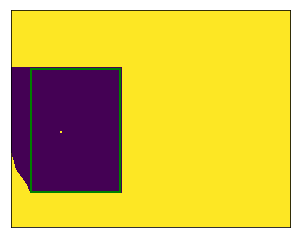

In [130]:
fig, ax = plt.subplots(1,1)
ax.imshow(outside | nodule_mask)
patch = patches.Rectangle((x1,y1), width, height, edgecolor='green', facecolor='None', linewidth=2)
ax.add_patch(patch)

In [131]:
x2 = int(x1 + width)
y2 = int(y1 + height)
x1 = int(x1)
y1 = int(y1)

In [132]:
x1, x2, y1, y2

(20, 112, 60, 186)

In [133]:
(x2-x1), (y2-y1)

(92, 126)

In [134]:
y_max, y_min, x_max, x_min

(126, 125, 51, 50)

In [135]:
# x_max, pad_or_crop_0, x_max + pad_or_crop_0

In [136]:
# (x2 - poc_0_half) - x_max,  x_min - (x1 + poc_0_half)

In [137]:
# Check the dimensions of the rect found and see if we need to pad or crop (poc)
poc_0 = box_gan_size-(x2-x1)
poc_1 = box_gan_size-(y2-y1)
poc_0_half = poc_0//2 # Add up to poc_0_half to each direction
poc_1_half = poc_1//2

# Correction for images with odd dimensions
if poc_0 % 2 == 0: odd_0 = 0 
else: odd_0 = 1
if poc_1 % 2 == 0: odd_1 = 0 
else: odd_1 = 1

if poc_0 > 0: # pad
    if x2 + poc_0_half < np.shape(imgA)[1] and x1 - poc_0_half > 0: #padboth
        x1 = x1 - poc_0_half
        x2 = x2 + poc_0_half + odd_0
        
    elif x2 + poc_0_half < np.shape(imgA)[1]: # pad to the right
        x2 = x2 + poc_0
    else:
        x1 = x1 - poc_0 #pad to the left
else: # crop
    if (x2 - poc_0_half) - x_max > 0 and x_min - (x1 + poc_0_half) > 0:
        x1 = x1 - poc_0_half
        x2 = x2 + poc_0_half + odd_0
    elif (x2 - poc_0_half) - x_max > 0: # crop right
        x2 = x2 + poc_0
    else: # crop left
        x1 = x1 - poc_0
        
if poc_1 > 0: # pad
    if y2 + poc_1_half < np.shape(imgA)[0] and y1 - poc_1_half > 0: #padboth
        y1 = y1 - poc_1_half
        y2 = y2 + poc_1_half + odd_1
         
    elif y2 + poc_1_half < np.shape(imgA)[0]: # pad to the right
        y2 = y2 + poc_1
    else:
        y1 = y1 - poc_1 #pad to the left
else: # crop
    if (y2 - poc_1_half) - y_max > 0 and y_min - (y1 + poc_1_half) > 0:
        y1 = y1 - poc_1_half
        y2 = y2 + poc_1_half + odd_1
    elif (y2 - poc_1_half) - y_max > 0: # crop right
        y2 = y2 - poc_1
    else: # crop left
        y1 = y1 - poc_1

In [138]:
poc_0, poc_1, poc_0_half, poc_1_half, odd_0, odd_1

(36, 2, 18, 1, 0, 0)

In [139]:
x1, x2, y1, y2

(2, 130, 59, 187)

In [140]:
# x1, x2, y1, y2 = adjust_rect_to_size(box_gan_size, x1, x2, y1, y2)

In [141]:
x1, x2, y1, y2

(2, 130, 59, 187)

In [142]:
print(nsh(imgA), nsh(imgB))

(224, 288) (224, 288)


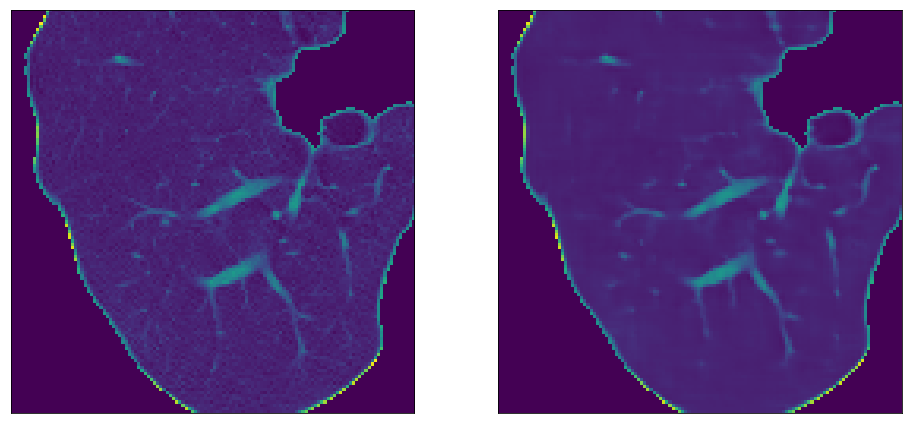

In [143]:
set_all_rcParams(False)
imgA_last = imgA[y1:y2,x1:x2]
imgB_last = imgB[y1:y2,x1:x2]
fig, ax = plt.subplots(1,2,figsize=(14, 6))
ax[0].imshow(imgA_last, vmin = 0, vmax = 1)
ax[1].imshow(imgB_last, vmin = 0, vmax = 1)
plt.tight_layout()

In [144]:
nsh(imgA_last), nsh(imgB_last)

((128, 128), (128, 128))

# End

In [1082]:
# # Check the dimensions of the rect found and see if we need to crop or pad
# pad_or_crop_0 = box_gan_size-(x2-x1)
# pad_or_crop_1 = box_gan_size-(y2-y1)
# if pad_or_crop_0 > 0: # pad
#     if x2 > 200: # pad to the left
#         x1 = x1 - pad_or_crop_0
#     else: # pad to the right
#         x2 = x2 + pad_or_crop_0
# else:
#     if x2 > 200: #crop left
#         x2 += pad_or_crop_0
#     else: # crop right
#         x1 -= pad_or_crop_0

# if pad_or_crop_1 > 0: #pad
#     if y2 > 200: # pad top
#         y1 -= pad_or_crop_1
#     else: # pad below
#         y2 += pad_or_crop_1
# else: #crop
#     if y2 > 200: #crop below
#         y2 += pad_or_crop_1
#     else: # crop top
#         y1 -= pad_or_crop_1